## Init notebook

This is run once.

## Preliminaries

In [1]:
import quantus

/home/lweber/work-code/Quantus/quantus/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-09-01 18:12:14.849147: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-01 18:12:16.008397: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:


# Import libraries.
from IPython.display import clear_output
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import warnings
import torch
import captum
import torchvision

from zennit import attribution as zattr
from zennit import image as zimage
from zennit import composites as zcomp

from models import models
from data import dataloaders, datasets, transforms
from attribution import zennit_utils as zutils
from utils import arguments as argument_utils
from main import *

try:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print('Using device:', torch.cuda.get_device_name(0))
except:
    pass

/home/lweber/work-code/Quantus/quantus/__init__.py
Using device: NVIDIA TITAN RTX


## Experiment



Preparing datasets...
DATA_ROOT /media/lweber/f3ed2aae-a7bf-4a55-b50d-ea8fb534f1f5/Datasets/imagenet/val
Number of Samples in Dataset: 1000
Reduced of Samples in Dataset: 100
Preparing dataloaders...


/home/lweber/work-code/Quantus/quantus/venv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/lweber/work-code/Quantus/quantus/venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for 

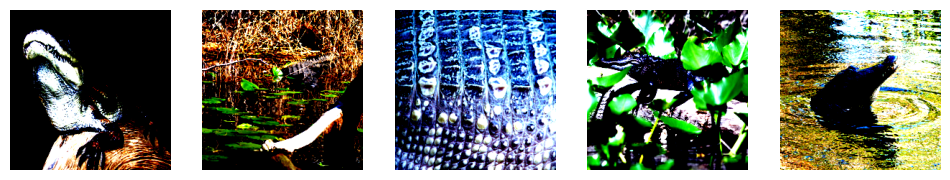

In [4]:
# Load data.
dataset_name = "imagenet"
model_name = "vgg16"
nr_test_samples = 100
num_classes = 1000
data_path = "/media/lweber/f3ed2aae-a7bf-4a55-b50d-ea8fb534f1f5/Datasets/imagenet"
labelmap_path = "label_map_imagenet.json"

# Get Dataset
# Prepare transforms
transform = transforms.get_transforms(dataset_name, mode="test")

# Prepare datasets
print("Preparing datasets...")
dataset = datasets.get_dataset(
    dataset_name,
    data_path,
    transform,
    mode="test",
    labelmap_path=labelmap_path
)

print(f"Number of Samples in Dataset: {len(dataset.samples)}")
dataset.samples = dataset.samples[:nr_test_samples]
print(f"Reduced of Samples in Dataset: {len(dataset.samples)}")

# Prepare dataloaders
print("Preparing dataloaders...")
loader = dataloaders.get_dataloader(
    dataset_name = dataset_name,
    dataset = dataset,
    batch_size = 32,
    shuffle = True,
)
# Prepare model
model = models.get_model(model_name, device)
model.eval()

for i, (batch, labels) in enumerate(loader):

    x_batch = batch.numpy()

    img_size = x_batch.shape[2]
    nr_channels = x_batch.shape[1]

    # Plot the data!
    fix, ax = plt.subplots(1, 5, figsize=(12, 4))
    for i in range(5):
        ax[i].imshow(np.moveaxis(x_batch[i], 0, -1).reshape(img_size, img_size, nr_channels))
        ax[i].axis("off")
    plt.show()

    break

In [5]:
quantus.AVAILABLE_XAI_METHODS_CAPTUM

['GradientShap',
 'IntegratedGradients',
 'DeepLift',
 'DeepLiftShap',
 'InputXGradient',
 'Saliency',
 'FeatureAblation',
 'Deconvolution',
 'FeaturePermutation',
 'Lime',
 'KernelShap',
 'LRP',
 'Gradient',
 'Occlusion',
 'LayerGradCam',
 'GuidedGradCam',
 'LayerConductance',
 'LayerActivation',
 'InternalInfluence',
 'LayerGradientXActivation',
 'Control Var. Sobel Filter',
 'Control Var. Constant',
 'Control Var. Random Uniform']

In [6]:
XAI_METHOD_KWARGS = {
    "Gradient": {
        "xai_lib": "zennit",
        "attributor": zattr.Gradient,
        "canonizer": None,
        "composite": None,
        "canonizer_kwargs": {},
        "composite_kwargs": {},
        "device": device,
    },
    "SmoothGrad": {
        "xai_lib": "zennit",
        "attributor": zattr.SmoothGrad,
        "attributor_kwargs": {
            "n_iter": 20,
            "noise_level": 0.1
        },
        "canonizer": None,
        "composite": None,
        "canonizer_kwargs": {},
        "composite_kwargs": {},
        "device": device,
    },
    "IntegratedGradients": {
        "xai_lib": "zennit",
        "attributor": zattr.IntegratedGradients,
        "attributor_kwargs": {
            "n_iter": 20,
        },
        "canonizer": None,
        "composite": None,
        "canonizer_kwargs": {},
        "composite_kwargs": {},
        "device": device,
    },
    "LRP-Eps": {
        "xai_lib": "zennit",
        "attributor": zattr.Gradient,
        "composite": zutils.Epsilon,
        "canonizer": zutils.get_zennit_canonizer(model),
        "canonizer_kwargs": {},
        "composite_kwargs": {
            "stabilizer": 1e-6,
            "epsilon": 1e-6
        },
        "device": device,
    },
    "LRP-Z+": {
        "xai_lib": "zennit",
        "attributor": zattr.Gradient,
        "composite": zutils.ZPlus,
        "canonizer": zutils.get_zennit_canonizer(model),
        "canonizer_kwargs": {},
        "composite_kwargs": {
            "stabilizer": 1e-6,
        },
        "device": device,
    },
    "Guided-Backprop": {
        "xai_lib": "zennit",
        "attributor": zattr.Gradient,
        "canonizer": None,
        "composite": zcomp.GuidedBackprop,
        "canonizer_kwargs": {},
        "composite_kwargs": {},
        "device": device,
    },
    "KernelShap" : {
        "xai_lib": "captum",
        "device": device,
        "method": "KernelShap"
    },
    "Lime" : {
        "xai_lib": "captum",
        "device": device,
        "method": "Lime"
    }
}

In [9]:
# Load explanation methods.
xai_setting = ["Gradient", "LRP-Eps", "LRP-Z+", "SmoothGrad", "IntegratedGradients"] #KernelShap, Lime

xai_methods = {s:XAI_METHOD_KWARGS[s] for s in xai_setting}
xai_methods

{'Gradient': {'xai_lib': 'zennit',
  'attributor': zennit.attribution.Gradient,
  'canonizer': None,
  'composite': None,
  'canonizer_kwargs': {},
  'composite_kwargs': {},
  'device': device(type='cuda', index=0)},
 'LRP-Eps': {'xai_lib': 'zennit',
  'attributor': zennit.attribution.Gradient,
  'composite': attribution.zennit_utils.Epsilon,
  'canonizer': zennit.torchvision.VGGCanonizer,
  'canonizer_kwargs': {},
  'composite_kwargs': {'stabilizer': 1e-06, 'epsilon': 1e-06},
  'device': device(type='cuda', index=0)},
 'LRP-Z+': {'xai_lib': 'zennit',
  'attributor': zennit.attribution.Gradient,
  'composite': attribution.zennit_utils.ZPlus,
  'canonizer': zennit.torchvision.VGGCanonizer,
  'canonizer_kwargs': {},
  'composite_kwargs': {'stabilizer': 1e-06},
  'device': device(type='cuda', index=0)},
 'SmoothGrad': {'xai_lib': 'zennit',
  'attributor': zennit.attribution.SmoothGrad,
  'attributor_kwargs': {'n_iter': 20, 'noise_level': 0.1},
  'canonizer': None,
  'composite': None,
  '

Parameter Config:
nr_samples: 50, quality_func: <function discrete_entropy at 0x7fd1015c7940>, quality_func_kwargs: {'n_bins': 387}, abs: False, normalise: False, layer_order: bottom_up


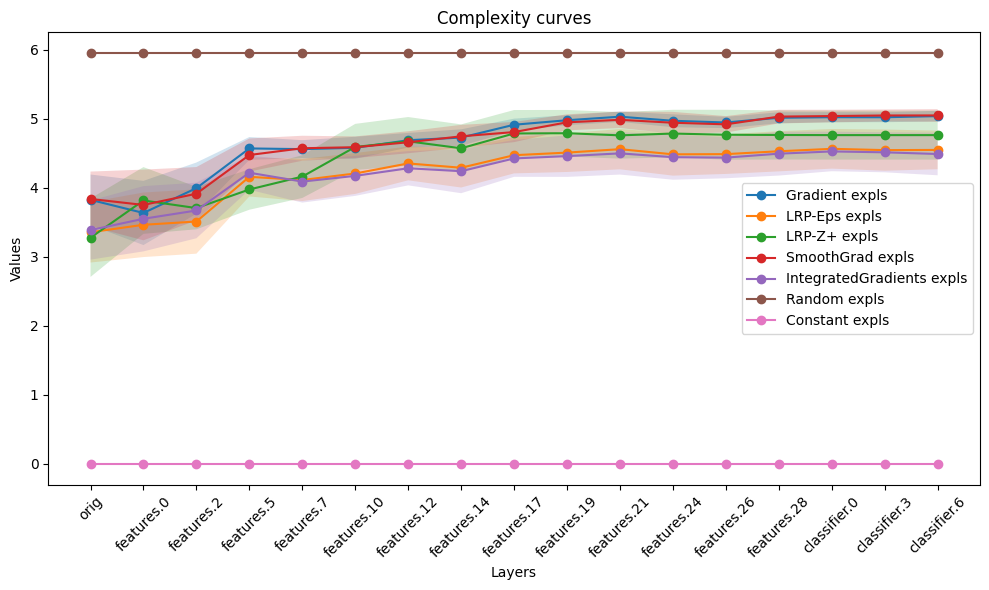

Parameter Config:
nr_samples: 50, quality_func: <function discrete_entropy at 0x7fd1015c7940>, quality_func_kwargs: {'n_bins': 387}, abs: False, normalise: False, layer_order: top_down


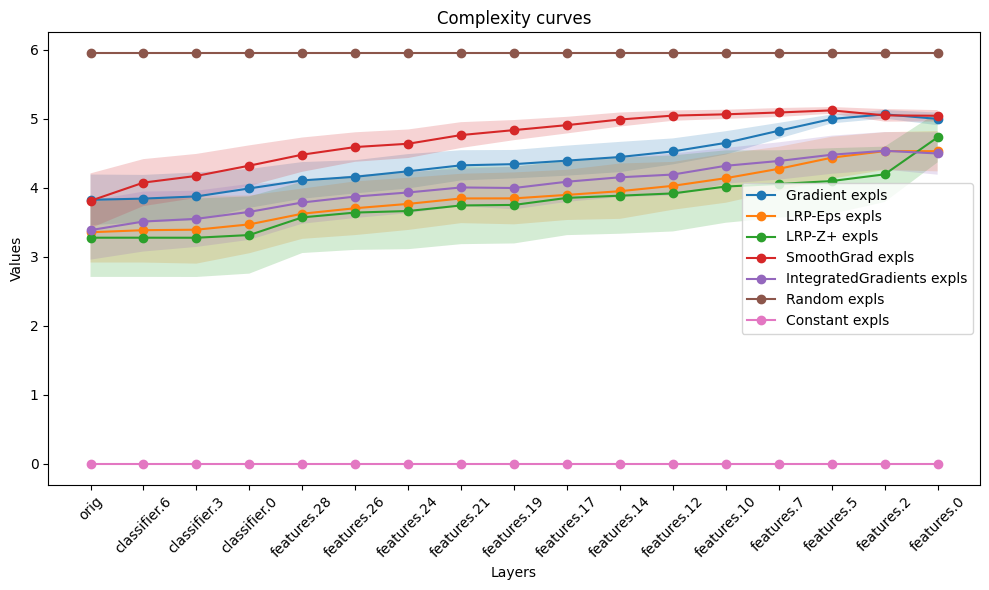

Parameter Config:
nr_samples: 50, quality_func: <function gini_coeffiient at 0x7fd1015c7820>, abs: False, normalise: True, normalise_func: <function normalise_and_shift_by_minmax at 0x7fd10d2f1820>, layer_order: bottom_up


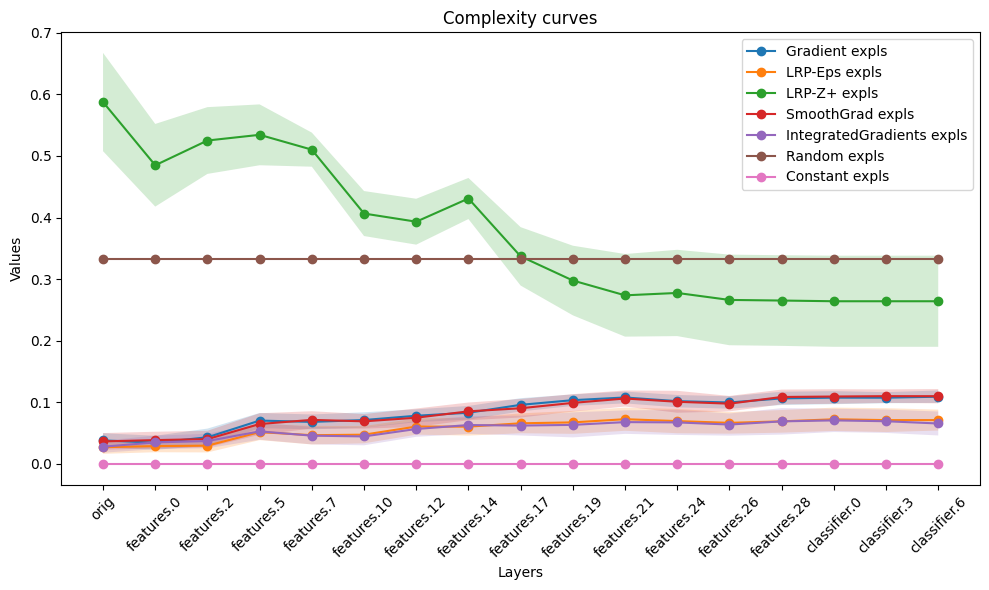

Parameter Config:
nr_samples: 50, quality_func: <function gini_coeffiient at 0x7fd1015c7820>, abs: False, normalise: True, normalise_func: <function normalise_and_shift_by_minmax at 0x7fd10d2f1820>, layer_order: top_down


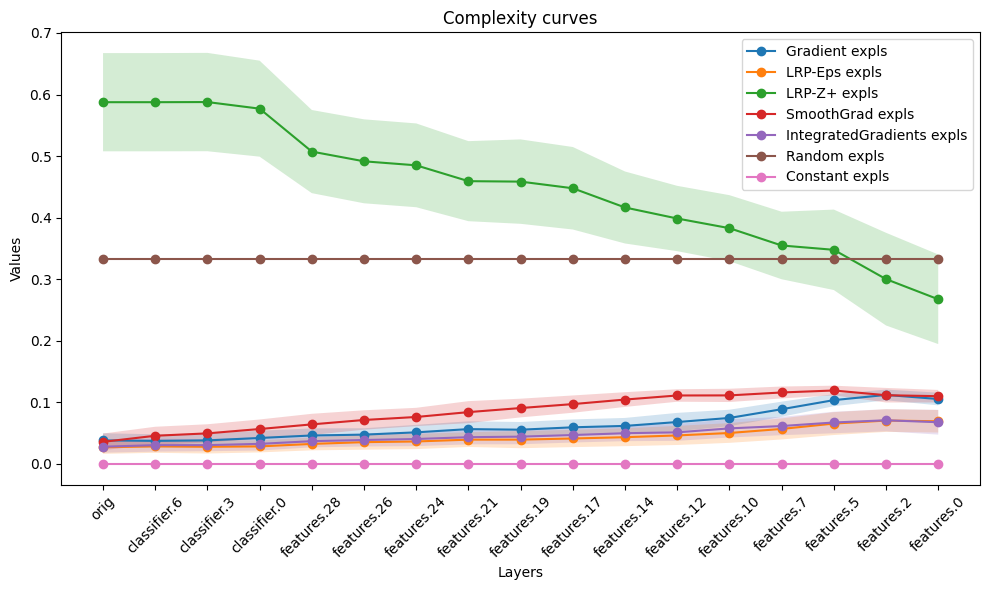

In [10]:

n_bins = int(np.sqrt(len(x_batch[0].flatten())))

from quantus.functions.normalise_func import normalise_and_shift_by_minmax
metric_param_configs = [
    {
        "nr_samples": 50,
        "quality_func": quantus.complexity_func.discrete_entropy,
        "quality_func_kwargs": {"n_bins": n_bins},
        "abs": False,
        "normalise": False,
        "layer_order": "bottom_up"
    },
    {
        "nr_samples": 50,
        "quality_func": quantus.complexity_func.discrete_entropy,
        "quality_func_kwargs": {"n_bins": n_bins},
        "abs": False,
        "normalise": False,
        "layer_order": "top_down"
    },
    # {
    #     "nr_samples": 50,
    #     "quality_func": quantus.complexity_func.gini_coeffiient,
    #     "abs": False,
    #     "normalise": True,
    #     "normalise_func": normalise_and_shift_by_minmax,
    #     "layer_order": "bottom_up"
    # },
    # {
    #     "nr_samples": 50,
    #     "quality_func": quantus.complexity_func.gini_coeffiient,
    #     "abs": False,
    #     "normalise": True,
    #     "normalise_func": normalise_and_shift_by_minmax,
    #     "layer_order": "top_down"
    # },
    # {
    #     "nr_samples": 50,
    #     "quality_func": quantus.complexity_func.median_local_variance,
    #     "quality_func_kwargs": {"k": 5},
    #     "abs": False,
    #     "normalise": False,
    #     "layer_order": "bottom_up"
    # },
    # {
    #     "nr_samples": 50,
    #     "quality_func": quantus.complexity_func.median_local_variance,
    #     "quality_func_kwargs": {"k": 5},
    #     "abs": False,
    #     "normalise": False,
    #     "layer_order": "top_down"
    # },
]

for param_config in metric_param_configs:
    scores = {}
    param_config_str = ""
    for k, v in param_config.items():
        param_config_str += f"{k}: {v}, "
    param_config_str = param_config_str[:-2]
    print("Parameter Config:")
    print(param_config_str)

    for xai_method, xai_method_kwargs in xai_methods.items():

        scores[xai_method] = {}

        # Return local MPT_Complexity estimate scores in an one-liner - by calling the metric instance.
        metric = quantus.eMPRT(
                #layer_order="bottom_up",
                return_sample_quality=False,
                #quality_func=quality_func,
                #quality_func_kwargs={"n_bins": quality_func_kwargs}
                #nr_samples=nr_samples,
                #abs=abs,
                #normalise=normalise,
                #normalise_func=quantus.normalise_by_max,
                return_aggregate=False,
                disable_warnings=True,
                **param_config
            )

        scores[xai_method]["scores_expl_random"] = []
        scores[xai_method]["scores_expl_constant"] = []
        scores[xai_method]["scores_expl_model_randomised"] = {}

        for i, (batch, labels) in enumerate(loader):

            #print("Evaluating Batch {}/{}".format(i+1, len(loader)))

            batch_results = metric(
                model=model,
                x_batch=batch.numpy(),
                y_batch=labels.numpy(),
                a_batch=None,
                device=device,
                explain_func=quantus.explain,
                explain_func_kwargs={**{"method": xai_method}, **xai_method_kwargs}
            )

            # Results are returned/saved as a dictionary not like in the super-class as a list.
            for s in metric.scores_expl_random:
                scores[xai_method]["scores_expl_random"].append(s)
            for s in metric.scores_expl_constant:
                scores[xai_method]["scores_expl_constant"].append(s)
            for k in metric.scores_expl_model_randomised.keys():
                if k not in scores[xai_method]["scores_expl_model_randomised"].keys():
                    scores[xai_method]["scores_expl_model_randomised"][k] = []
                scores[xai_method]["scores_expl_model_randomised"][k] += metric.scores_expl_model_randomised[k]

    def replace_none(x):
        return x if x is not None else np.nan

    plt.figure(figsize=(10, 6))

    for method, data in scores.items():
        means = []
        stds = []
        layer_names = []
        for layer, values in data["scores_expl_model_randomised"].items():
            layer_names.append(layer)
            values = np.vectorize(replace_none)(values)
            means.append(np.nanmean(values))
            stds.append(np.nanstd(values))

        # Plot!
        plt.plot(layer_names, means, 'o-', label=method + " expls")
        plt.fill_between(layer_names, np.array(means) + np.array(stds), np.array(means) - np.array(stds), alpha=0.2)

    # Plot!
    scores_random = np.vectorize(replace_none)(scores[xai_method]["scores_expl_random"])
    scores_random_means = np.full(len(layer_names), np.nanmean(scores_random))
    scores_random_stds = np.full(len(layer_names), np.nanstd(scores_random))
    plt.plot(layer_names, scores_random_means, 'o-', label="Random" + " expls")
    plt.fill_between(layer_names, scores_random_means + scores_random_stds, scores_random_means - scores_random_stds, alpha=0.2)

    # Plot!
    scores_random = np.vectorize(replace_none)(scores[xai_method]["scores_expl_constant"])
    scores_random_means = np.full(len(layer_names), np.nanmean(scores_random))
    scores_random_stds = np.full(len(layer_names), np.nanstd(scores_random))
    plt.plot(layer_names, scores_random_means, 'o-', label="Constant" + " expls")
    plt.fill_between(layer_names, scores_random_means + scores_random_stds, scores_random_means - scores_random_stds, alpha=0.2)

    plt.xticks(rotation=45)
    plt.xlabel('Layers')
    plt.ylabel('Values')
    plt.title(f'Complexity curves')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [8]:
# def replace_none(x):
#     return x if x is not None else np.nan

# plt.figure(figsize=(10, 6))

# for method, data in scores.items():
#     means = []
#     stds = []
#     layer_names = []
#     for layer, values in data["scores_expl_model_randomised"].items():
#         layer_names.append(layer)
#         values = np.vectorize(replace_none)(values)
#         means.append(np.nanmean(values))
#         stds.append(np.nanstd(values))

#     # Plot!
#     plt.plot(layer_names, means, 'o-', label=method + " expls")
#     plt.fill_between(layer_names, np.array(means) + np.array(stds), np.array(means) - np.array(stds), alpha=0.2)

# # Plot!
# scores_random = np.vectorize(replace_none)(scores[xai_method]["scores_expl_random"])
# scores_random_means = np.full(len(layer_names), np.nanmean(scores_random))
# scores_random_stds = np.full(len(layer_names), np.nanstd(scores_random))
# plt.plot(layer_names, scores_random_means, 'o-', label="Random" + " expls")
# plt.fill_between(layer_names, scores_random_means + scores_random_stds, scores_random_means - scores_random_stds, alpha=0.2)

# # Plot!
# scores_random = np.vectorize(replace_none)(scores[xai_method]["scores_expl_constant"])
# scores_random_means = np.full(len(layer_names), np.nanmean(scores_random))
# scores_random_stds = np.full(len(layer_names), np.nanstd(scores_random))
# plt.plot(layer_names, scores_random_means, 'o-', label="Constant" + " expls")
# plt.fill_between(layer_names, scores_random_means + scores_random_stds, scores_random_means - scores_random_stds, alpha=0.2)

# plt.xticks(rotation=45)
# plt.xlabel('Layers')
# plt.ylabel('Values')
# plt.title(f'Complexity curves')
# plt.legend()
# plt.tight_layout()
# plt.show()